In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.typing as npt
import math
import requests
import aiohttp
import asyncio
import ujson as json
import QuantLib as ql
import warnings
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.optimize import fmin
from datetime import datetime, timedelta
from typing import List, Optional
from collections import OrderedDict

from nelson_siegel_svensson.calibrate import calibrate_ns_ols, errorfn_ns_ols
from fredapi import Fred

from fetch_treasuries import multi_download_year_treasury_par_yield_curve_rate
from utils import plot_yield_curves

import nest_asyncio
nest_asyncio.apply()

from dotenv import dotenv_values
config = dotenv_values(".env")

sns.set(style="whitegrid", palette="dark")
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
dir_path = r"C:\Users\chris\tactical-treasuries-treasure\data" 
years = [str(x) for x in range(2024, 1989, -1)]
ust_daily_data = multi_download_year_treasury_par_yield_curve_rate(years, dir_path, run_all=True)

In [207]:
df_par_rates = ust_daily_data["daily_treasury_yield_curve"]
df_par_rates["Date"] = pd.to_datetime(df_par_rates["Date"])
df_par_rates = df_par_rates[
    (df_par_rates["Date"] > datetime(2007, 1, 1))
]

# Treasury's official yield curve is a par yield curve derived using a monotone convex method from bid-side market price quotations 
# (not actual transactions) for the most recently auctioned securities obtained by the Federal Reserve Bank of New York at or near 3:30 PM each trading day
df_par_rates

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2024-05-31,5.48,5.48,5.46,5.46,5.42,5.18,4.89,4.69,4.52,4.52,4.51,4.73,4.65
1,2024-05-30,5.48,5.48,5.46,5.48,5.42,5.19,4.92,4.74,4.57,4.57,4.55,4.76,4.69
2,2024-05-29,5.50,5.48,5.46,5.47,5.43,5.22,4.96,4.79,4.63,4.63,4.61,4.82,4.74
3,2024-05-28,5.50,5.48,5.46,5.51,5.43,5.21,4.94,4.75,4.56,4.56,4.54,4.74,4.66
4,2024-05-24,5.56,5.53,5.46,5.51,5.44,5.21,4.93,4.71,4.53,4.49,4.46,4.65,4.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4355,2007-01-08,4.87,NaN,5.08,NaN,5.13,5.01,4.78,4.70,4.66,4.66,4.66,4.84,4.74
4356,2007-01-05,4.81,NaN,5.05,NaN,5.09,4.98,4.76,4.68,4.65,4.65,4.65,4.84,4.74
4357,2007-01-04,4.80,NaN,5.04,NaN,5.07,4.95,4.71,4.63,4.61,4.61,4.62,4.81,4.72
4358,2007-01-03,4.84,NaN,5.05,NaN,5.09,4.98,4.76,4.69,4.66,4.66,4.67,4.85,4.77


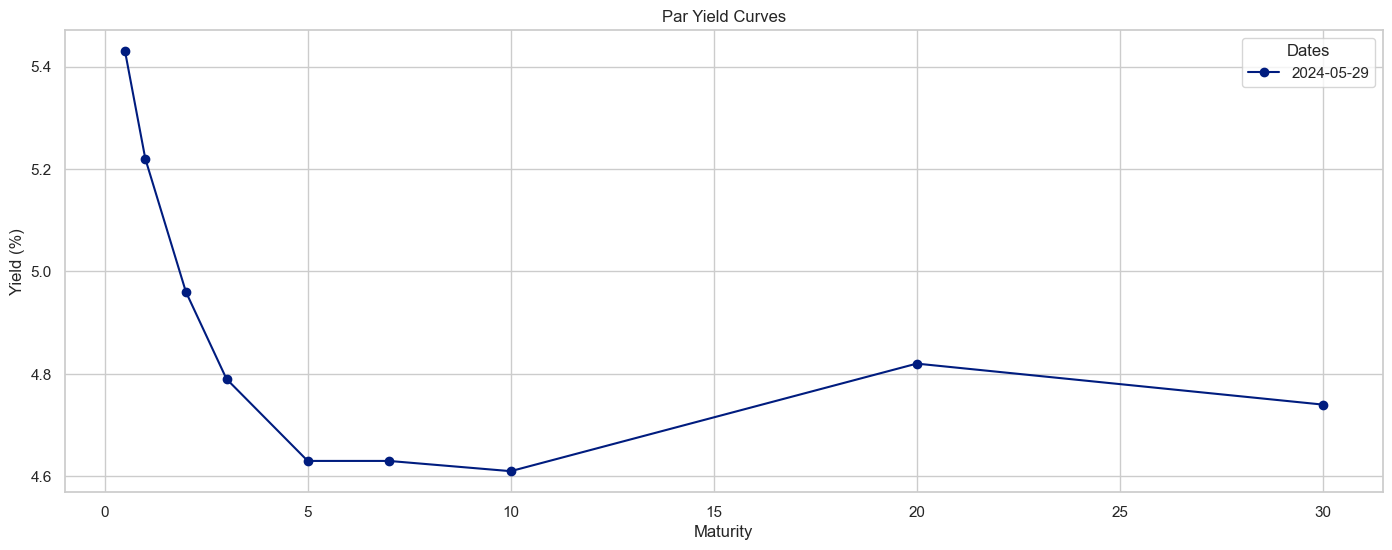

In [279]:
df_par_rates.drop(df_par_rates.columns[[1, 2, 3, 4]], axis=1, inplace=True)

plot_yield_curves(
    df_par_rates,
    dates=[
        datetime(2024, 5, 29),
        # datetime(2024, 4, 23),
        # datetime(2024, 3, 22),
        # datetime(2024, 2, 22),
    ],
    title="Par Yield Curves",
)

In [205]:
! python3.12 schwab_treasuries.py 2000 market_observed_usts_auctioned_after_2000.xlsx

In [208]:
try:
    sofr_obj = requests.get("https://markets.newyorkfed.org/api/rates/all/latest.json").json()["refRates"][5]
    print(json.dumps(sofr_obj, indent=4))
except:
    fred = Fred(api_key=config["FRED_API_KEY"])
    sofr_series = fred.get_series("SOFR")
    sofr_obj = {
        "effectiveDate": sofr_series.index[-1],
        "percentRate": sofr_series[-1]
    }

In [209]:
df_observed_usts = pd.read_excel("market_observed_usts_auctioned_after_2000.xlsx")
df_observed_usts = df_observed_usts.sort_values("target_tenor")
df_observed_usts = df_observed_usts[
    (df_observed_usts["target_tenor"] > 0.25)
]

sofr_row = pd.DataFrame(
    {
        "CUSIP": f"SOFR as of {sofr_obj["effectiveDate"]}",
        "target_tenor": 0,
        "time_to_maturity": 0,
        "YTM": sofr_obj["percentRate"],
    },
    index=[0],
)
df_observed_usts = pd.concat([sofr_row, df_observed_usts]).reset_index(drop=True)
df_observed_usts

,CUSIP,target_tenor,time_to_maturity,YTM,Action,Description,Coupon,Maturity,Quote,Quantity,Price,Min,Max,YTW 1,Accrued Interest,Estimated Total,Market Depth
0,SOFR as of 2024-05-30 00:00:00,0.0,0.000000,5.330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CUSIP 912797LE5,0.5,0.473973,5.368,Buy,US Treasury BILL 11/21/2024 912797LE5,0.000,11/21/2024,Ask,1000.0,97.56100,1000.0,14400.0,--,--,975610.00,View for 912797LE5 CUSIP
2,CUSIP 912797LB1,1.0,0.953425,5.170,Buy,US Treasury BILL 05/15/2025 912797LB1,0.000,05/15/2025,Ask,1000.0,95.28700,1000.0,15000.0,--,--,952870.00,View for 912797LB1 CUSIP
3,CUSIP 9128285N6,1.5,1.498630,4.997,Buy,US Treasury 2.875% 11/30/2025 9128285N6,2.875,11/30/2025,Ask,250.0,96.99000,250.0,23000.0,--,78.55,242553.55,View for 9128285N6 CUSIP
4,CUSIP 91282CKS9,2.0,1.997260,4.857,Buy,US Treasury 4.875% 05/31/2026 91282CKS9 Rece...,4.875,05/31/2026,Ask,550.0,100.03400,550.0,78000.0,--,293.03,550480.03,View for 91282CKS9 CUSIP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,CUSIP 912810TD0,28.0,27.726027,4.677,Buy,US Treasury 2.25% 02/15/2052 912810TD0,2.250,02/15/2052,Ask,250.0,62.52344,250.0,30000.0,--,1699.86,158008.46,View for 912810TD0 CUSIP
57,CUSIP 912810TJ7,28.5,28.224658,4.674,Buy,US Treasury 3% 08/15/2052 912810TJ7,3.000,08/15/2052,Ask,250.0,73.91406,250.0,30000.0,--,2266.48,187051.64,View for 912810TJ7 CUSIP
58,CUSIP 912810TL2,29.0,28.476712,4.662,Buy,US Treasury 4% 11/15/2052 912810TL2,4.000,11/15/2052,Ask,250.0,89.62109,250.0,30000.0,--,543.48,224596.22,View for 912810TL2 CUSIP
59,CUSIP 912810TR9,29.5,28.972603,4.659,Buy,US Treasury 3.625% 05/15/2053 912810TR9,3.625,05/15/2053,Ask,250.0,83.65477,250.0,10000.0,--,492.53,209629.44,View for 912810TR9 CUSIP


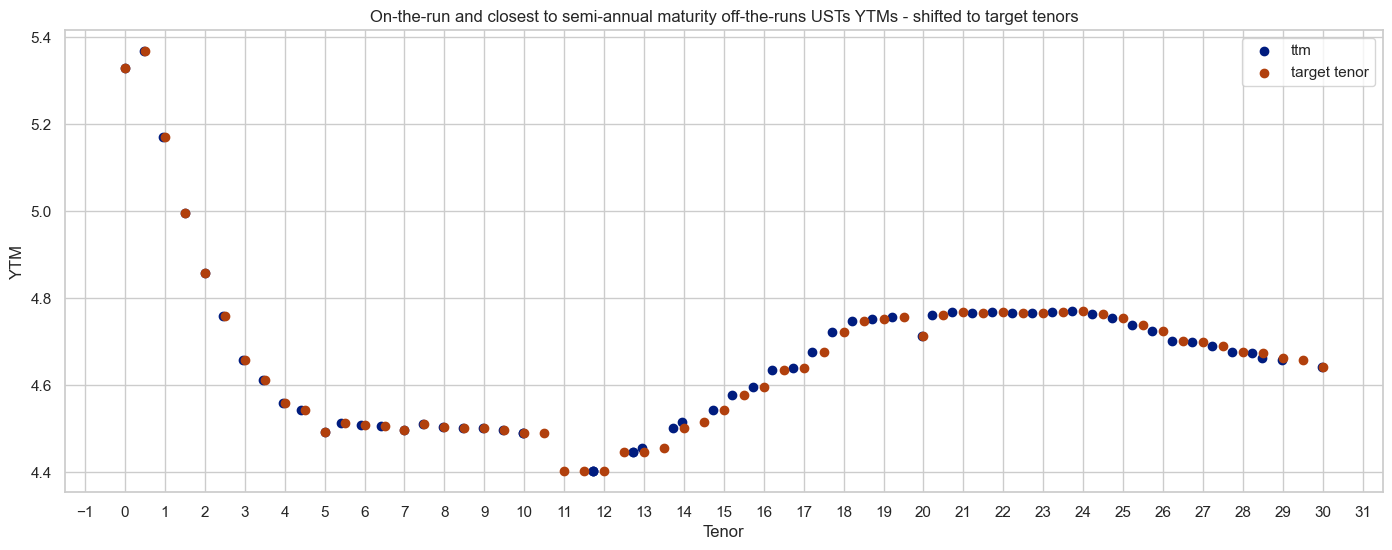

In [210]:
plt.figure(figsize=(17, 6))
plt.scatter(
    df_observed_usts["time_to_maturity"],
    df_observed_usts["YTM"],
    marker="o",
    label="ttm",
)
plt.scatter(
    df_observed_usts["target_tenor"],
    df_observed_usts["YTM"],
    marker="o",
    label="target tenor",
)
plt.title(
    "On-the-run and closest to semi-annual maturity off-the-runs USTs YTMs - shifted to target tenors"
)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Tenor")
plt.ylabel("YTM")
plt.grid(True)
plt.legend()
plt.show()

In [211]:
# Nelson-Siegel-Svensson Model
def nss(df: pd.DataFrame, β0=0.01, β1=0.01, β2=0.01, β3=0.01, λ0=1.00, λ1=1.00, maturity_key="time_to_maturity", nss_key="NSS"):
    df[nss_key] = (
        (β0)
        + (
            β1
            * (
                (1 - np.exp(-df[maturity_key] / λ0))
                / (df[maturity_key] / λ0)
            )
        )
        + (
            β2
            * (
                (
                    (
                        (1 - np.exp(-df[maturity_key] / λ0))
                        / (df[maturity_key] / λ0)
                    )
                )
                - (np.exp(-df[maturity_key] / λ0))
            )
        )
        + (
            β3
            * (
                (
                    (
                        (1 - np.exp(-df[maturity_key] / λ1))
                        / (df[maturity_key] / λ1)
                    )
                )
                - (np.exp(-df[maturity_key] / λ1))
            )
        )
    )
    return df

In [212]:
df_observed_usts_subset = df_observed_usts[
    ["CUSIP", "time_to_maturity", "YTM", "Price", "Coupon"]
]

target_tenors = list(df_observed_usts["target_tenor"])
new_rows_count = len(target_tenors)
existing_rows_count = len(df_observed_usts_subset)
df_observed_usts_subset_new = pd.DataFrame(
    index=range(existing_rows_count, existing_rows_count + new_rows_count),
    columns=df_observed_usts_subset.columns,
)
df_observed_usts_subset_new["time_to_maturity"] = target_tenors
df_observed_usts_subset = pd.concat(
    [df_observed_usts_subset, df_observed_usts_subset_new], ignore_index=True
)
df_observed_usts_subset.loc[
    existing_rows_count:, df_observed_usts_subset.columns != "time_to_maturity"
] = np.nan
df_observed_usts_subset = df_observed_usts_subset.sort_values("time_to_maturity")
df_observed_usts_subset = df_observed_usts_subset.reset_index(drop=True)
df_observed_usts_subset = df_observed_usts_subset.drop(1)

df_observed_usts_subset = nss(df=df_observed_usts_subset, nss_key="NSS_unfitted")
df_observed_usts_subset["NSS_unfitted"] = round(
    df_observed_usts_subset["NSS_unfitted"] * 100, 4
)
df_observed_usts_subset.at[0, "NSS_unfitted"] = df_observed_usts_subset.at[0, "YTM"]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    display(df_observed_usts_subset)

,CUSIP,time_to_maturity,YTM,Price,Coupon,NSS_unfitted
0,SOFR as of 2024-05-30 00:00:00,0.000000,5.330,NaN,NaN,5.3300
2,CUSIP 912797LE5,0.473973,5.368,97.56100,0.000,2.1442
3,NaN,0.500000,NaN,NaN,NaN,2.1478
4,CUSIP 912797LB1,0.953425,5.170,95.28700,0.000,2.1630
5,NaN,1.000000,NaN,NaN,NaN,2.1606
6,CUSIP 9128285N6,1.498630,4.997,96.99000,2.875,2.1077
7,NaN,1.500000,NaN,NaN,NaN,2.1075
8,CUSIP 91282CKS9,1.997260,4.857,100.03400,4.875,2.0268
9,NaN,2.000000,NaN,NaN,NaN,2.0263
10,CUSIP 912828U24,2.457534,4.759,93.69922,2.000,1.9449


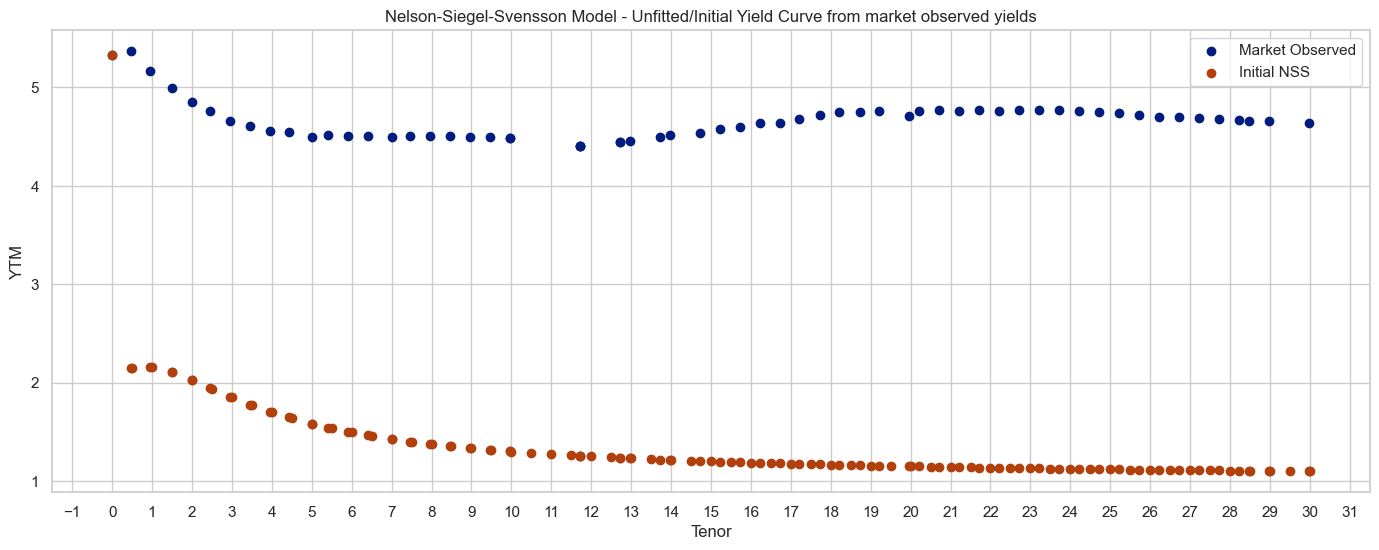

In [213]:
plt.figure(figsize=(17, 6))
plt.scatter(
    df_observed_usts_subset["time_to_maturity"],
    df_observed_usts_subset["YTM"],
    marker="o",
    label="Market Observed",
)
plt.scatter(
    df_observed_usts_subset["time_to_maturity"],
    df_observed_usts_subset["NSS_unfitted"],
    marker="o",
    label="Initial NSS",
)
plt.title(
    "Nelson-Siegel-Svensson Model - Unfitted/Initial Yield Curve from market observed yields"
)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Tenor")
plt.ylabel("YTM")
plt.grid(True)
plt.legend()
plt.show()

In [214]:
def minimize_residual(c: List[float]) -> npt.NDArray[np.float64]:
    df = df_observed_usts_subset.copy() 
    df["NSS_fitted"] = (
        (c[0])
        + (
            c[1]
            * (
                (1 - np.exp(-df["time_to_maturity"] / c[4]))
                / (df["time_to_maturity"] / c[4])
            )
        )
        + (
            c[2]
            * (
                (
                    (
                        (1 - np.exp(-df["time_to_maturity"] / c[4]))
                        / (df["time_to_maturity"] / c[4])
                    )
                )
                - (np.exp(-df["time_to_maturity"] / c[4]))
            )
        )
        + (
            c[3]
            * (
                (
                    (
                        (1 - np.exp(-df["time_to_maturity"] / c[5]))
                        / (df["time_to_maturity"] / c[5])
                    )
                )
                - (np.exp(-df["time_to_maturity"] / c[5]))
            )
        )
    )
    df["NSS_fitted"] = round(df["NSS_fitted"] * 100, 4)
    df["residual_fitted"] = (df["YTM"] - df["NSS_fitted"]) ** 2
    val = np.sum(df["residual_fitted"])
    # print("[β0, β1, β2, β3, λ0, λ1]=", c, ", SUM:", val)
    return val


c = fmin(minimize_residual, [0.01, 0.01, 0.01, 0.01, 1.00, 1.00])
c

Optimization terminated successfully.
         Current function value: 0.238909
         Iterations: 501
         Function evaluations: 812


array([ 0.049997  , -0.02782677,  0.0520274 , -0.019797  ,  0.17673699,
        3.67460204])

In [215]:
β0 = c[0]
β1 = c[1]
β2 = c[2]
β3 = c[3]
λ0 = c[4]
λ1 = c[5]
print(
    "[β0, β1, β2, β3, λ0, λ1]=",
    [
        c[0].round(6),
        c[1].round(6),
        c[2].round(6),
        c[3].round(6),
        c[4].round(6),
        c[5].round(6),
    ],
)

[β0, β1, β2, β3, λ0, λ1]= [0.049997, -0.027827, 0.052027, -0.019797, 0.176737, 3.674602]


In [216]:
df_observed_usts_nss_fitted = nss(
    df=df_observed_usts_subset,
    β0=β0,
    β1=β1,
    β2=β2,
    β3=β3,
    λ0=λ0,
    λ1=λ1,
    nss_key="NSS_fitted",
)

df_observed_usts_nss_fitted["NSS_fitted"] = round(
    df_observed_usts_nss_fitted["NSS_fitted"] * 100, 4
)
df_observed_usts_nss_fitted.at[0, "NSS_fitted"] = df_observed_usts_nss_fitted.at[0, "YTM"]

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_observed_usts_nss_fitted)

,CUSIP,time_to_maturity,YTM,Price,Coupon,NSS_unfitted,NSS_fitted
0,SOFR as of 2024-05-30 00:00:00,0.000000,5.330,NaN,NaN,5.3300,5.3300
2,CUSIP 912797LE5,0.473973,5.368,97.56100,0.000,2.1442,5.3671
3,NaN,0.500000,NaN,NaN,NaN,2.1478,5.3742
4,CUSIP 912797LB1,0.953425,5.170,95.28700,0.000,2.1630,5.2062
5,NaN,1.000000,NaN,NaN,NaN,2.1606,5.1826
6,CUSIP 9128285N6,1.498630,4.997,96.99000,2.875,2.1077,4.9749
7,NaN,1.500000,NaN,NaN,NaN,2.1075,4.9745
8,CUSIP 91282CKS9,1.997260,4.857,100.03400,4.875,2.0268,4.8361
9,NaN,2.000000,NaN,NaN,NaN,2.0263,4.8355
10,CUSIP 912828U24,2.457534,4.759,93.69922,2.000,1.9449,4.7444


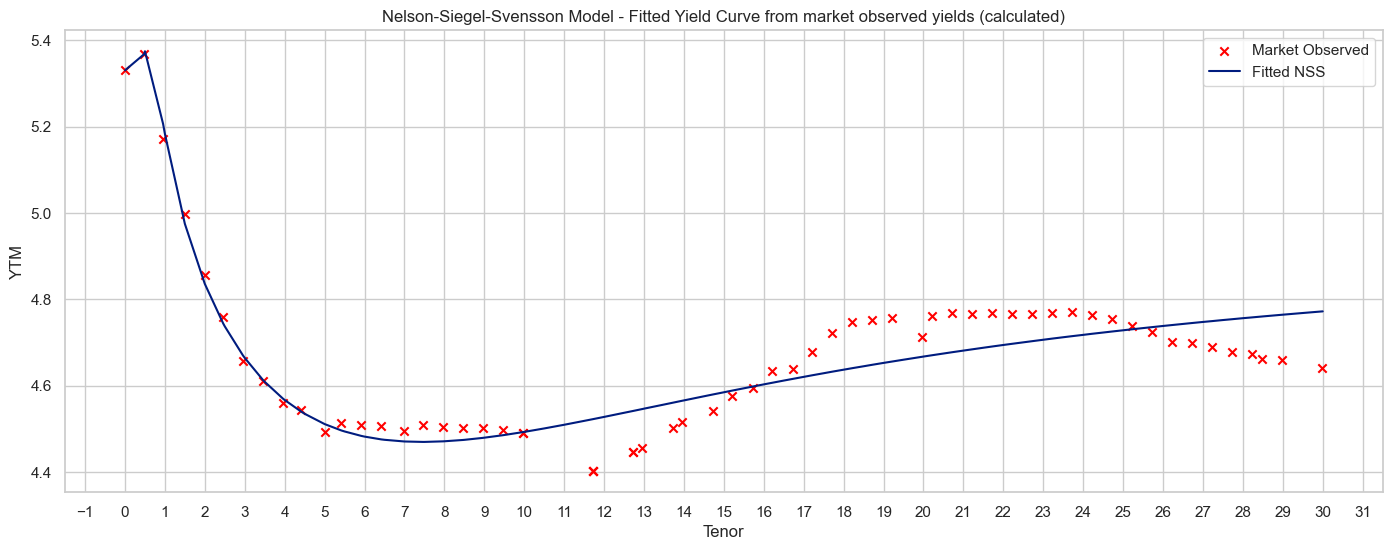

In [217]:
plt.figure(figsize=(17, 6))
plt.scatter(
    df_observed_usts_nss_fitted["time_to_maturity"],
    df_observed_usts_nss_fitted["YTM"],
    marker="x",
    color="red",
    label="Market Observed",
)
plt.plot(
    df_observed_usts_nss_fitted["time_to_maturity"],
    df_observed_usts_nss_fitted["NSS_fitted"],
    label="Fitted NSS",
)
plt.title(
    "Nelson-Siegel-Svensson Model - Fitted Yield Curve from market observed yields (calculated)"
)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Tenor")
plt.ylabel("YTM")
plt.grid(True)
plt.legend()
plt.show()

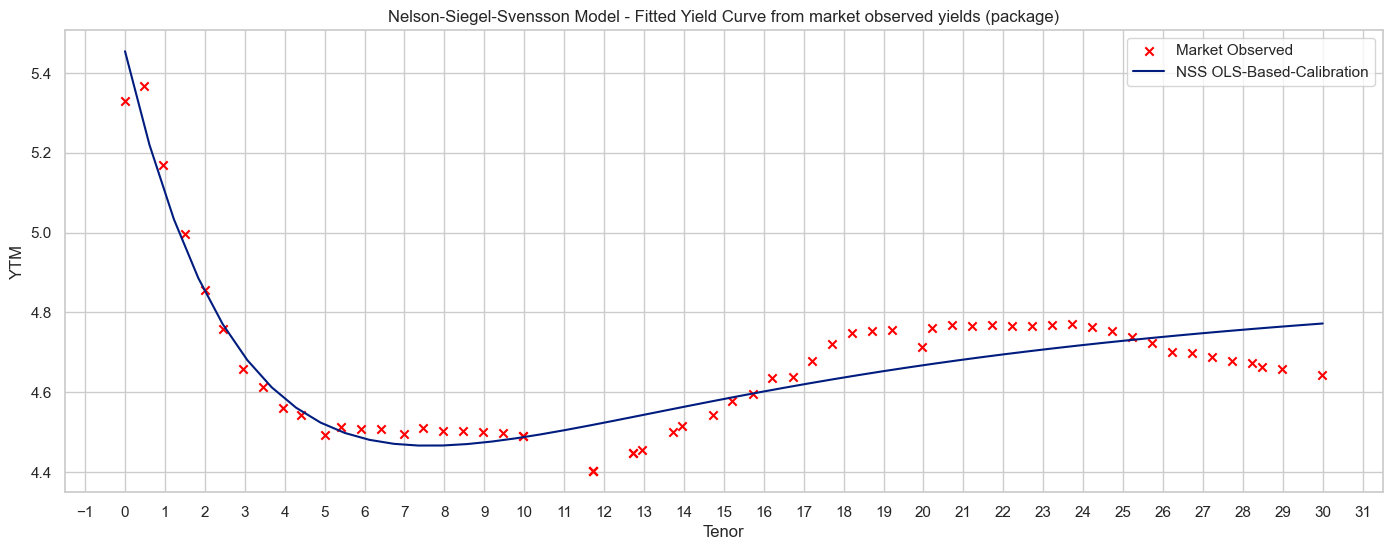

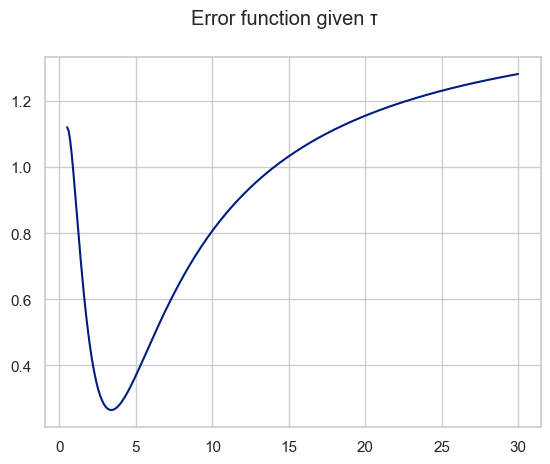

In [218]:
curve, status = calibrate_ns_ols(
    df_observed_usts["time_to_maturity"].values,
    df_observed_usts["YTM"].values,
    tau0=1.0,
)
assert status.success

t2 = np.linspace(0, 30)
plt.figure(figsize=(17, 6))
plt.scatter(
    df_observed_usts["time_to_maturity"],
    df_observed_usts["YTM"],
    marker="x",
    color="red",
    label="Market Observed",
)
plt.plot(t2, curve(t2), "b-", label="NSS OLS-Based-Calibration")
plt.title(
    "Nelson-Siegel-Svensson Model - Fitted Yield Curve from market observed yields (package)"
)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Tenor")
plt.ylabel("YTM")
plt.grid(True)
plt.legend()
plt.show()

taus = np.linspace(0.5, 30, 300)
err = np.array(
    [
        errorfn_ns_ols(
            tau,
            df_observed_usts["time_to_maturity"].values,
            df_observed_usts["YTM"].values,
        )
        for tau in taus
    ]
)
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("Error function given τ")
ax.plot(taus, err)

In [219]:
off_the_run_maturities = {0.5 + i for i in range(30)} | {x for x in range(1, 31)}
on_the_runs_maturities = {0, 0.5, 1, 2, 3, 5, 7, 10, 20, 30}
clean_tenors = list(on_the_runs_maturities | off_the_run_maturities)
clean_tenors.sort()
fitted_ust_curve_df = df_observed_usts_nss_fitted[
    df_observed_usts_nss_fitted["time_to_maturity"].isin(clean_tenors)
]
fitted_ust_curve_df = fitted_ust_curve_df[
    ~fitted_ust_curve_df["time_to_maturity"].duplicated(keep=False)
]

fitted_ust_curve_df

,CUSIP,time_to_maturity,YTM,Price,Coupon,NSS_unfitted,NSS_fitted
0,SOFR as of 2024-05-30 00:00:00,0.0,5.33,NaN,NaN,5.3300,5.3300
3,NaN,0.5,NaN,NaN,NaN,2.1478,5.3742
5,NaN,1.0,NaN,NaN,NaN,2.1606,5.1826
7,NaN,1.5,NaN,NaN,NaN,2.1075,4.9745
9,NaN,2.0,NaN,NaN,NaN,2.0263,4.8355
11,NaN,2.5,NaN,NaN,NaN,1.9373,4.7372
13,NaN,3.0,NaN,NaN,NaN,1.8506,4.6643
15,NaN,3.5,NaN,NaN,NaN,1.7709,4.6090
17,NaN,4.0,NaN,NaN,NaN,1.6996,4.5669
19,NaN,4.5,NaN,NaN,NaN,1.6370,4.5350


In [220]:
depo_maturities = [ql.Period(6,ql.Months), ql.Period(12, ql.Months)]
depo_rates = list(fitted_ust_curve_df["NSS_fitted"])[1:3]

bond_maturities = [ql.Period(6*i, ql.Months) for i in range(3,61)]
bond_rates = list(fitted_ust_curve_df["NSS_fitted"])[2:]

In [221]:
calc_date = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = calc_date

calendar = ql.UnitedStates(m=ql.UnitedStates.GovernmentBond)
bussiness_convention = ql.Unadjusted
day_count = ql.Thirty360(ql.Thirty360.BondBasis)
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = ql.Period(ql.Semiannual)
settlement_days = 0

depo_helpers = [
    ql.DepositRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(r / 100.0)),
        m,
        settlement_days,
        calendar,
        bussiness_convention,
        end_of_month,
        day_count,
    )
    for r, m in zip(depo_rates, depo_maturities)
]

bond_helpers = []
for r, m in zip(bond_rates, bond_maturities):
    termination_date = calc_date + m
    schedule = ql.Schedule(
        calc_date,
        termination_date,
        coupon_frequency,
        calendar,
        bussiness_convention,
        bussiness_convention,
        ql.DateGeneration.Backward,
        end_of_month,
    )

    helper = ql.FixedRateBondHelper(
        ql.QuoteHandle(ql.SimpleQuote(face_amount)),
        settlement_days,
        face_amount,
        schedule,
        [r / 100.0],
        day_count,
        bussiness_convention,
    )
    bond_helpers.append(helper)

rate_helpers = depo_helpers + bond_helpers
# yieldcurve = ql.PiecewiseLogLinearDiscount(calc_date, rate_helpers, day_count)
# yieldcurve = ql.PiecewiseLogCubicDiscount(calc_date, rate_helpers, day_count)
# yieldcurve = ql.PiecewiseLinearZero(calc_date, rate_helpers, day_count)
# yieldcurve = ql.PiecewiseCubicZero(calc_date, rate_helpers, day_count)
# yieldcurve = ql.PiecewiseLinearForward(calc_date, rate_helpers, day_count)
yieldcurve = ql.PiecewiseSplineCubicDiscount(calc_date, rate_helpers, day_count)
# instantaneous_fwd_curve = ql.ForwardSpreadedTermStructure(
#     ql.YieldTermStructureHandle(yieldcurve), ql.QuoteHandle(ql.SimpleQuote(0.0))
# )
forward_term_structure = ql.YieldTermStructureHandle(yieldcurve)
forward_term_structure.enableExtrapolation()

In [222]:
spots = []
forwards = []
oneyear_forwards = []
tenors = []
for d in yieldcurve.dates():
    yrs = day_count.yearFraction(calc_date, d)
    compounding = ql.Compounded
    freq = ql.Semiannual
    zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
    tenors.append(yrs)
    eq_rate = zero_rate.equivalentRate(
        day_count, compounding, freq, calc_date, d
    ).rate()
    spots.append(100 * eq_rate)
    forwards.append(forward_term_structure.forwardRate(d, d, day_count, ql.Compounded).rate() * 100)
    oneyear_forwards.append(forward_term_structure.forwardRate(d, d + ql.Period('1Y'), ql.Actual360(), ql.Compounded).rate() * 100)

C:\Users\chris\AppData\Local\Temp\ipykernel_17744\3205256520.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(


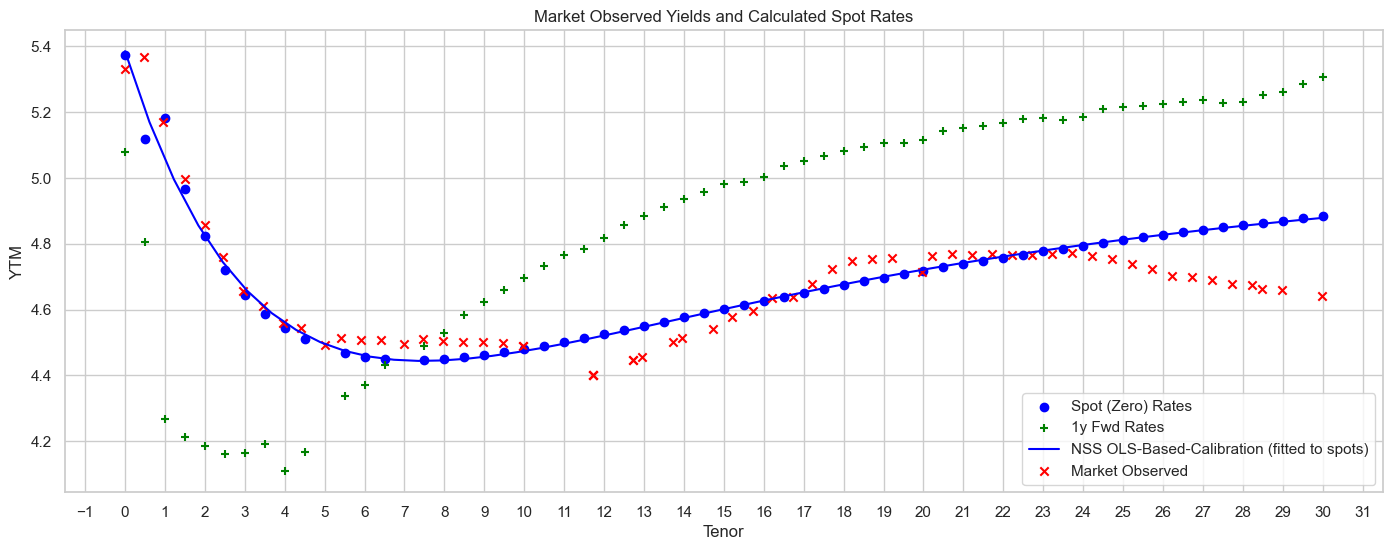

In [223]:
curve, status = calibrate_ns_ols(
    fitted_ust_curve_df["time_to_maturity"].values,
    np.array(spots[1:]),
    tau0=1.0,
)
assert status.success

t2 = np.linspace(0, 30)

plt.figure(figsize=(17, 6))

plt.scatter(
    list(fitted_ust_curve_df["time_to_maturity"]),
    spots[1:],
    marker="o",
    color="blue",
    label="Spot (Zero) Rates",
)
plt.scatter(
    list(fitted_ust_curve_df["time_to_maturity"]),
    oneyear_forwards[1:],
    marker="+",
    color="green",
    label="1y Fwd Rates",
)
plt.plot(
    t2,
    curve(t2),
    "b-",
    label="NSS OLS-Based-Calibration (fitted to spots)",
    color="blue",
)
plt.scatter(
    df_observed_usts["time_to_maturity"],
    df_observed_usts["YTM"],
    marker="x",
    color="red",
    label="Market Observed",
)

plt.title("Market Observed Yields and Calculated Spot Rates")
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Tenor")
plt.ylabel("YTM")
plt.grid(True)
plt.legend()
plt.show()